# Team 3: Sutcliffe (Trenberth) Forcing in a Layer

## 1) Imports

In [1]:
import sys
sys.path.append('/home/decker/lab433')

from datetime import datetime

from synoptic import MODEL, get_dataset

from metpy.units import units
from metpy.constants import dry_air_gas_constant as R
from metpy.io import GempakGrid
import metpy.calc as mpcalc
from metpy.plots import FilledContourPlot, MapPanel, PanelContainer
import xarray as xr

## 2) Get the data

In [2]:
gem_file_name = MODEL + 'nam/24101612_nam211.gem'
gem_file = GempakGrid(gem_file_name)

In [3]:
plot_time = datetime(2024, 10, 16, 18)
# More code below
#ds = get_dataset(gem_file, plot_time)

## 3) Calculate

In [4]:
#finding p
p1 = 300
p2 = 850
delta_p = 850-300

#extracting from data set
ht850 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=850)[0]
#u850 = gem_file.gdxarray(parameter='UREL', date_time=plot_time, level=850)[0]
#v850 = gem_file.gdxarray(parameter='VREL', date_time=plot_time, level=850)[0]

ht850 = ht850 * units('m')
#u850 = u850 * units('m/s')
#v850 = v850 * units('m/s')

ht300 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=300)[0]
#u300 = gem_file.gdxarray(parameter='UREL', date_time=plot_time, level=300)[0]
#v300 = gem_file.gdxarray(parameter='VREL', date_time=plot_time, level=300)[0]

ht300 = ht300 * units('m')
#u300 = u300 * units('m/s')
#v300 = v300 * units('m/s')

#smoothing
smoothing = 16
ht850 = mpcalc.smooth_gaussian(ht850, smoothing)
ht300 = mpcalc.smooth_gaussian(ht300, smoothing)
#u850 = mpcalc.smooth_gaussian(u850, smoothing)
#u300 = mpcalc.smooth_gaussian(u300, smoothing)
#v850 = mpcalc.smooth_gaussian(v850, smoothing)
#v300 = mpcalc.smooth_gaussian(v300, smoothing)

#finding Vt
(Vg1_u, Vg1_v) = mpcalc.geostrophic_wind(ht300)
(Vg2_u, Vg2_v) = mpcalc.geostrophic_wind(ht850)

Vg1_u = Vg1_u.rename('u')
Vg1_v = Vg1_v.rename('v')

Vg1 = xr.merge([Vg1_u,Vg1_v])

Vg2_u = Vg2_u.rename('u')
Vg2_v = Vg2_v.rename('v')

Vg2 = xr.merge([Vg2_u,Vg2_v])

Vt = Vg1 - Vg2

#coriolis
fo =  mpcalc.coriolis_parameter(Vt['latitude'])

#finding vorticity
Vg1u = Vg1_u.squeeze(dim='pres')
Vg2u = Vg2_u.squeeze(dim='pres')
Vg1v = Vg1_v.squeeze(dim='pres')
Vg2v = Vg2_v.squeeze(dim='pres')
Cg1 = mpcalc.vorticity(Vg1u, Vg1v)
Cg2 = mpcalc.vorticity(Vg2u, Vg2v)

Cg = (Cg1 + Cg2)/2

#advection term
#(-Vt * Cg)
Vti = Vg1_u.squeeze(dim='pres') - Vg2_u.squeeze(dim='pres')
Vtj = Vg1_v.squeeze(dim='pres') - Vg2_v.squeeze(dim='pres')

advection = mpcalc.advection(Cg, Vti, Vtj)

#finding the F equation
F = (((2 * fo)/delta_p) * (advection))

/tmp/ipykernel_10372/1206923855.py:66: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  advection = mpcalc.advection(Cg, Vti, Vtj)


## 4) Plot it

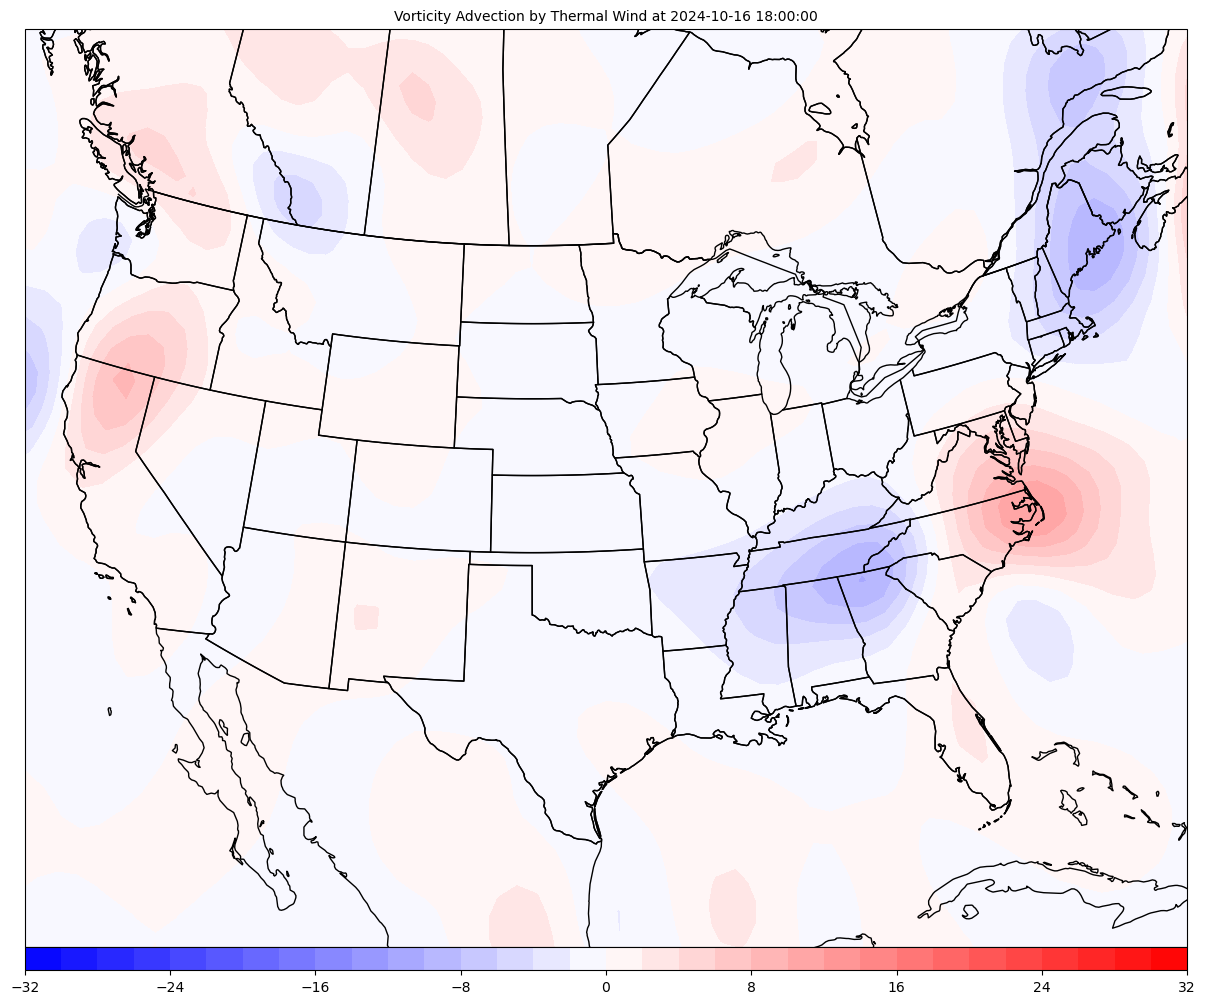

In [5]:
d1 = FilledContourPlot()
d1.data = F
d1.time = plot_time
d1.contours = list(range(-32, 33, 2))
d1.colorbar = 'horizontal'
d1.colormap = 'bwr'
d1.scale = 5e15

panel = MapPanel()
panel.area = [-120, -74, 22, 55]
panel.projection = 'lcc'
panel.layers = ['states', 'coastline', 'borders']
panel.title = f'Vorticity Advection by Thermal Wind at {plot_time}'
panel.plots = [d1]

pc = PanelContainer()
pc.size = (15, 15)
pc.panels = [panel]
pc.show()